# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs


# Lab 2: PyTorch Breast Cancer Histopathological Image Classification using Convolutional Neural Networks

https://bayesian-ai.trydiscourse.com/t/12-applied-deep-learning-labs-2-breast-cancer-classification/21

<img src="assets/hist.png" align="center">

## Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 

<img src="assets/pt.jpg" width="35%" align="center">

## Progress

- [x] PyTorch DataSet
- [x] PyTorch DataLoader
- [x] Augmentations


# Breast Cancer Histopathological Databases 


###  BreakHis 

The BreaKHis database contains microscopic biopsy images of benign and malignant breast tumors. Images were
collected through a clinical study from January 2014 to December 2014. All patients referred to the P&D Lab, Brazil,
during this period of time, with a clinical indication of BC were invited to participate in the study. The institutional
review board approved the study and all patients gave written informed consent. All the data were anonymized

https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/
- Download: http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz

###  Kaggle 162 H&E
This dataset consists of 5547 breast histology images of size 50 x 50 x 3, curated from Andrew Janowczyk website and used for a data science tutorial at Epidemium. The goal is to classify cancerous images (IDC : invasive ductal carcinoma) vs non-IDC images.

The dataset consists of 277,524 50x50 pixel RGB digital image patches that were derived from 162 H&E-stained breast histopathology samples. These images are small patches that were extracted from digital images of breast tissue samples. The breast tissue contains many cells but only some of them are cancerous. Patches that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma. For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

http://www.andrewjanowczyk.com/use-case-6-invasive-ductal-carcinoma-idc-segmentation/


- Download: https://www.kaggle.com/simjeg/lymphoma-subtype-classification-fl-vs-cll or http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip


## Links:
- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924


# For Windows 10 with CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

## The PyTorch DataLoader Class:
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


## Google Colab version:

## Colab links:
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
- https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [1]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.3.1.post2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from kmodels import *
from kdataset import *

# Define Custom Dataset

In [3]:
import os
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

dataset='IDC_regular_ps50_idx5' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017 d:\db\data\IDC_regular_ps50_idx5\
data_dir= 'd:/db/data/' +  dataset
# data_dir_valid= 'd:/db/data/' +  dataset + '/valid/'


## Print single image

Number of images: 277524
d:/db/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
d:/db/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
d:/db/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
d:/db/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
d:/db/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png


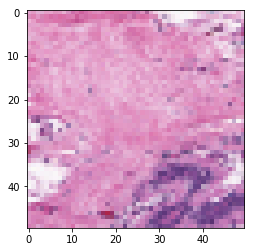

In [4]:
imageList = glob(data_dir + '/**/*.png', recursive=True)
print ( "Number of images: {}". format (len (imageList)))
for img in imageList[0:5]:
    print(img)
    
%matplotlib inline
pil_im = Image.open(imageList[0], 'r')
imshow(np.asarray(pil_im))

## Print a grid of images

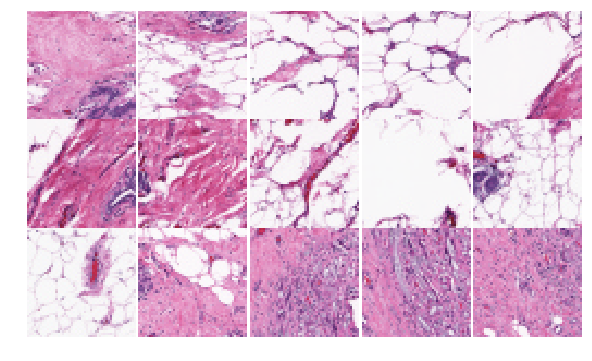

In [5]:
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in imageList[:15]:
    pil_im = Image.open(l, 'r')        
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(np.asarray(pil_im)); 
    plt.axis('off')
    i_ += 1

In [6]:
import os
import fnmatch
import os, sys, pdb, shutil, time, random
import argparse
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
import sys

class GenericDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]  # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]  # category_id
        #         print (labels)
        if self.transform:
            image = self.transform(image)
        return image, labels
  
    
    @staticmethod
    def find_classes_breast(fullDir):
        
        imageList = glob(fullDir + '/**/*.png', recursive=True)

        benign = '*class0.png'
        malignant = '*class1.png'
        classZero = fnmatch.filter(imageList, benign)
        classOne = fnmatch.filter(imageList, malignant)
#         print("benign:",classZero[0:5],'\n')
#         print("malignant:",classOne[0:5])
        
        class_to_idx= {'benign': 0, 'malignant': 1}
        num_to_class= {0: 'benign', 1: 'malignant'}
        classes= ['benign', 'malignant']
        
        print('Classes: {}'.format(classes))
        print('class_to_idx: {}'.format(class_to_idx))
        print('num_to_class: {}'.format(num_to_class))

        train = []
        for currImage_on_disk in classZero:
             if os.path.isfile(currImage_on_disk):                
                train.append(['{}'.format(currImage_on_disk), 'benign', class_to_idx['benign']])

        for currImage_on_disk in classOne:
             if os.path.isfile(currImage_on_disk):                
                train.append(['{}'.format(currImage_on_disk), 'malignant', class_to_idx['malignant']])        
                    
        df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])
        df.to_csv('full_labels_breast.csv', index=None)
        return classes, class_to_idx, num_to_class, df




In [7]:
classes, class_to_idx, num_to_class, df =GenericDataset.find_classes_breast (data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

Classes: ['benign', 'malignant']
class_to_idx: {'benign': 0, 'malignant': 1}
num_to_class: {0: 'benign', 1: 'malignant'}
['benign', 'malignant']
{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


,file,category,category_id
0,d:/db/data/IDC_regular_ps50_idx5\10253\0\10253...,benign,0
1,d:/db/data/IDC_regular_ps50_idx5\10253\0\10253...,benign,0
2,d:/db/data/IDC_regular_ps50_idx5\10253\0\10253...,benign,0
3,d:/db/data/IDC_regular_ps50_idx5\10253\0\10253...,benign,0
4,d:/db/data/IDC_regular_ps50_idx5\10253\0\10253...,benign,0


In [8]:
len(classes)

2

# Target distribution : Train set

c:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


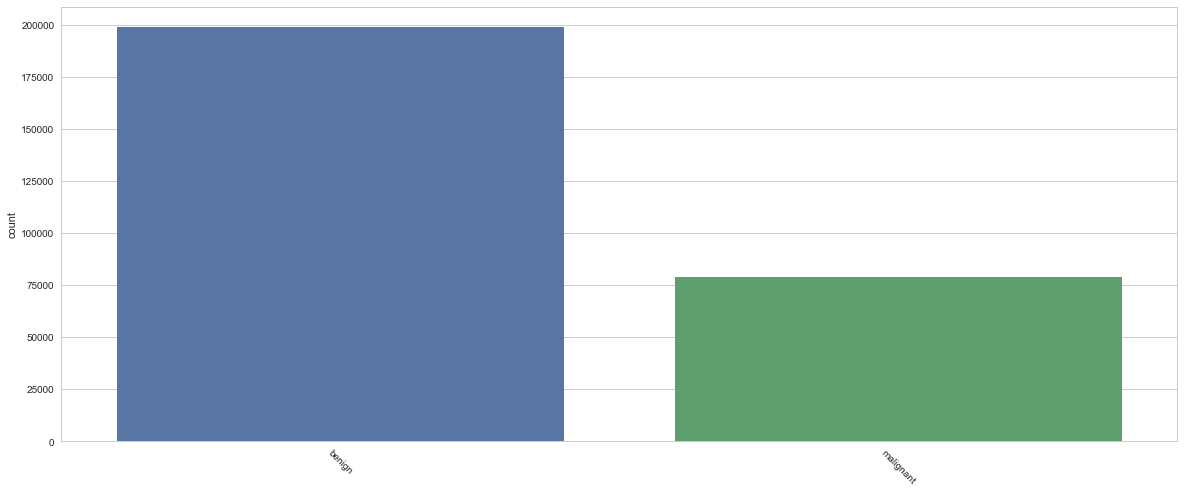

In [9]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: [x])
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

# Augmentation 

In [10]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

from ktransforms import *

## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

{'train': 47179, 'valid': 8326, 'test': 222019}
0    33608
1    13571
Name: category_id, dtype: int64


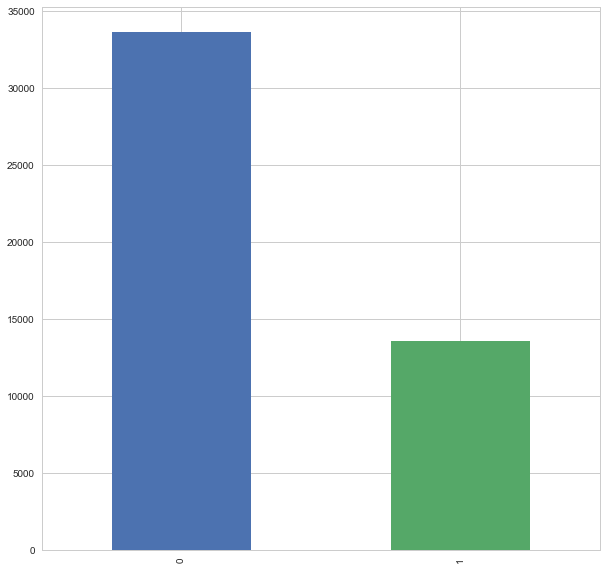

In [28]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 16


full_data = df.sample(frac=0.20) # save for testing (not validation)
# full_data = full_data.sample(frac=0.10) # DATA SET IS VERY LARGE use a sample

test_data = df[~df['file'].isin(full_data['file'])]
test_set = GenericDataset(test_data, data_dir, transform = valid_trans)

# Train validation split
train_data = full_data.sample(frac=0.85)
valid_data = full_data[~full_data['file'].isin(train_data['file'])]
train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset),
    'test': len(test_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

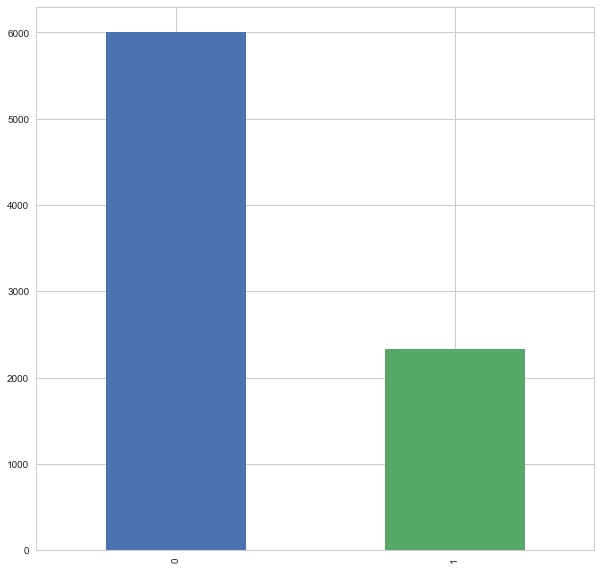

In [12]:
valid_data['category_id'].value_counts().plot(kind='bar')

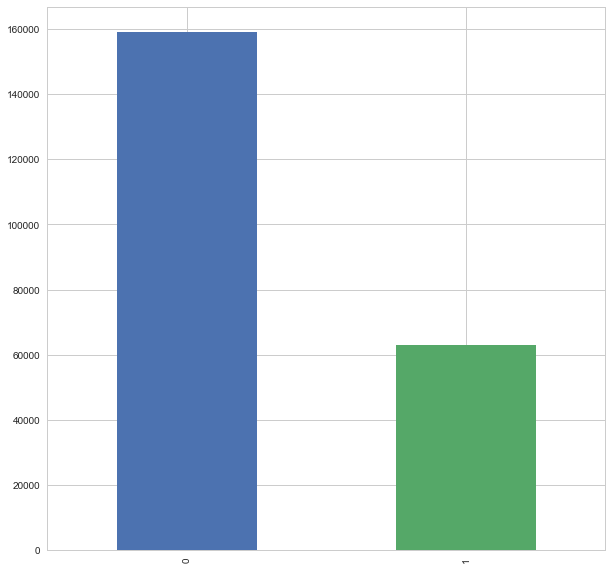

In [13]:
test_data['category_id'].value_counts().plot(kind='bar')

### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


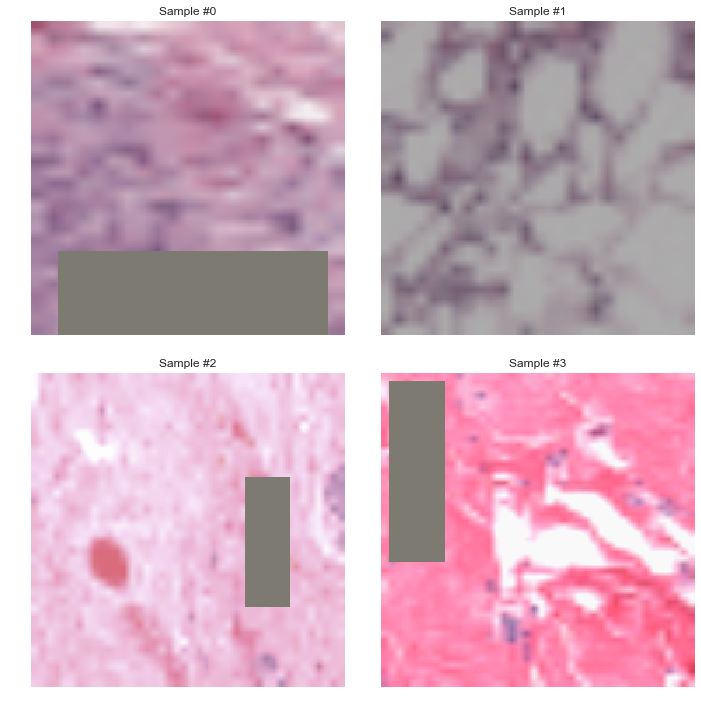

In [15]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    

plt.figure(figsize=[10,10])
# if __name__ == '__main__':  
for i, data in enumerate(t_loader, 0):
    print('i=%d: '%(i))            
    images, labels = data            
    num = len(images)

    ax = plt.subplot(2,2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (flaotTensorToImage(image))

    if i==imagesToShow-1:
        break            

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
# model =dpn92(len(classes))
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

SimpleNet(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (cnn1): ConvCNN(
    (math): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1), ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn2): ConvCNN(
    (math): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn3): ConvCNN(
    (math): Sequential(
      (0): Conv2d(64, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2,

# Metrics and Tensorboard

In [17]:
import datetime 

from utils import *

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

### Training

In [18]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 1000  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 1000== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Train the model

In [19]:
if __name__ == '__main__':  
    epochs=50
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(90.0):            
            print ("EARLY STOP")                        
            torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

Random Seed: 999
python version : 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
torch  version : 0.3.1.post2
cudnn  version : 7003
=> Final model name 'SimpleNet'
MODEL: SimpleNet
dataset: IDC_regular_ps50_idx5
    Total params: 1.07M
MODEL: SimpleNet


  0%|                                                                                                                                                            | 0/50 [00:00<?, ?it/s]

TRAIN: LOSS-->0.6858 (0.6858)	ACC-->43.750% (43.750%)
TRAIN: 0 [0/47179 (0%)]	Loss: 0.685824, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->0.4744 (0.4664)	ACC-->81.250% (78.921%)
TRAIN: 0 [16000/47179 (34%)]	Loss: 0.474359, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4316 (0.4576)	ACC-->81.250% (79.407%)
TRAIN: 0 [32000/47179 (68%)]	Loss: 0.431585, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4800 (0.4800)	ACC-->81.250 (81.250)
 * Accuracy 83.1011


  2%|██▉                                                                                                                                              | 1/50 [03:50<3:08:11, 230.44s/it]

TRAIN: LOSS-->0.5086 (0.5086)	ACC-->62.500% (62.500%)
TRAIN: 1 [0/47179 (0%)]	Loss: 0.508603, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.3255 (0.4348)	ACC-->87.500% (80.769%)
TRAIN: 1 [16000/47179 (34%)]	Loss: 0.325533, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5406 (0.4344)	ACC-->81.250% (80.819%)
TRAIN: 1 [32000/47179 (68%)]	Loss: 0.540555, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3245 (0.3245)	ACC-->81.250 (81.250)
 * Accuracy 83.6176


  4%|█████▊                                                                                                                                           | 2/50 [07:40<3:04:21, 230.45s/it]

TRAIN: LOSS-->0.2052 (0.2052)	ACC-->100.000% (100.000%)
TRAIN: 2 [0/47179 (0%)]	Loss: 0.205238, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4950 (0.4203)	ACC-->81.250% (81.568%)
TRAIN: 2 [16000/47179 (34%)]	Loss: 0.494985, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4220 (0.4238)	ACC-->93.750% (81.409%)
TRAIN: 2 [32000/47179 (68%)]	Loss: 0.422012, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0873 (0.0873)	ACC-->100.000 (100.000)
 * Accuracy 83.2332


  6%|████████▋                                                                                                                                        | 3/50 [11:31<3:00:28, 230.40s/it]

TRAIN: LOSS-->0.6665 (0.6665)	ACC-->75.000% (75.000%)
TRAIN: 3 [0/47179 (0%)]	Loss: 0.666542, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2402 (0.4137)	ACC-->87.500% (82.049%)
TRAIN: 3 [16000/47179 (34%)]	Loss: 0.240186, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3199 (0.4117)	ACC-->81.250% (82.003%)
TRAIN: 3 [32000/47179 (68%)]	Loss: 0.319923, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.8307 (0.8307)	ACC-->68.750 (68.750)
 * Accuracy 83.4975


  8%|███████████▌                                                                                                                                     | 4/50 [15:21<2:56:33, 230.29s/it]

TRAIN: LOSS-->0.2689 (0.2689)	ACC-->87.500% (87.500%)
TRAIN: 4 [0/47179 (0%)]	Loss: 0.268927, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6863 (0.3979)	ACC-->62.500% (82.792%)
TRAIN: 4 [16000/47179 (34%)]	Loss: 0.686265, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.3406 (0.3976)	ACC-->81.250% (82.787%)
TRAIN: 4 [32000/47179 (68%)]	Loss: 0.340644, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3819 (0.3819)	ACC-->81.250 (81.250)
 * Accuracy 85.0949


 10%|██████████████▌                                                                                                                                  | 5/50 [19:11<2:52:43, 230.30s/it]

TRAIN: LOSS-->0.3799 (0.3799)	ACC-->81.250% (81.250%)
TRAIN: 5 [0/47179 (0%)]	Loss: 0.379855, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4757 (0.3950)	ACC-->68.750% (83.029%)
TRAIN: 5 [16000/47179 (34%)]	Loss: 0.475693, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4438 (0.3961)	ACC-->81.250% (82.962%)
TRAIN: 5 [32000/47179 (68%)]	Loss: 0.443831, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3539 (0.3539)	ACC-->81.250 (81.250)
 * Accuracy 85.2270


 12%|█████████████████▍                                                                                                                               | 6/50 [23:01<2:48:53, 230.30s/it]

TRAIN: LOSS-->0.2660 (0.2660)	ACC-->100.000% (100.000%)
TRAIN: 6 [0/47179 (0%)]	Loss: 0.265973, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3199 (0.3924)	ACC-->93.750% (83.036%)
TRAIN: 6 [16000/47179 (34%)]	Loss: 0.319945, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2761 (0.3911)	ACC-->87.500% (83.130%)
TRAIN: 6 [32000/47179 (68%)]	Loss: 0.276052, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3110 (0.3110)	ACC-->87.500 (87.500)
 * Accuracy 84.9748


 14%|████████████████████▎                                                                                                                            | 7/50 [26:52<2:45:06, 230.37s/it]

TRAIN: LOSS-->0.4424 (0.4424)	ACC-->75.000% (75.000%)
TRAIN: 7 [0/47179 (0%)]	Loss: 0.442358, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3407 (0.3986)	ACC-->93.750% (82.567%)
TRAIN: 7 [16000/47179 (34%)]	Loss: 0.340690, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3641 (0.3935)	ACC-->87.500% (82.921%)
TRAIN: 7 [32000/47179 (68%)]	Loss: 0.364083, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3144 (0.3144)	ACC-->87.500 (87.500)
 * Accuracy 85.2871


 16%|███████████████████████▏                                                                                                                         | 8/50 [30:46<2:41:31, 230.76s/it]

TRAIN: LOSS-->0.1661 (0.1661)	ACC-->93.750% (93.750%)
TRAIN: 8 [0/47179 (0%)]	Loss: 0.166128, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5757 (0.3860)	ACC-->75.000% (83.154%)
TRAIN: 8 [16000/47179 (34%)]	Loss: 0.575700, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2553 (0.3867)	ACC-->87.500% (83.133%)
TRAIN: 8 [32000/47179 (68%)]	Loss: 0.255314, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2903 (0.2903)	ACC-->81.250 (81.250)
 * Accuracy 85.7194


 18%|██████████████████████████                                                                                                                       | 9/50 [34:40<2:37:56, 231.13s/it]

TRAIN: LOSS-->0.5264 (0.5264)	ACC-->75.000% (75.000%)
TRAIN: 9 [0/47179 (0%)]	Loss: 0.526447, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5513 (0.3859)	ACC-->75.000% (83.167%)
TRAIN: 9 [16000/47179 (34%)]	Loss: 0.551265, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4711 (0.3866)	ACC-->75.000% (83.277%)
TRAIN: 9 [32000/47179 (68%)]	Loss: 0.471138, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4043 (0.4043)	ACC-->81.250 (81.250)
 * Accuracy 85.9116


 20%|████████████████████████████▊                                                                                                                   | 10/50 [38:32<2:34:08, 231.21s/it]

TRAIN: LOSS-->0.4231 (0.4231)	ACC-->81.250% (81.250%)
TRAIN: 10 [0/47179 (0%)]	Loss: 0.423065, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4743 (0.3852)	ACC-->75.000% (83.442%)
TRAIN: 10 [16000/47179 (34%)]	Loss: 0.474348, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2718 (0.3844)	ACC-->81.250% (83.271%)
TRAIN: 10 [32000/47179 (68%)]	Loss: 0.271793, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4143 (0.4143)	ACC-->93.750 (93.750)
 * Accuracy 85.2510


 22%|███████████████████████████████▋                                                                                                                | 11/50 [42:22<2:30:14, 231.14s/it]

TRAIN: LOSS-->0.3500 (0.3500)	ACC-->87.500% (87.500%)
TRAIN: 11 [0/47179 (0%)]	Loss: 0.349973, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2852 (0.3854)	ACC-->81.250% (83.129%)
TRAIN: 11 [16000/47179 (34%)]	Loss: 0.285233, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6083 (0.3838)	ACC-->81.250% (83.274%)
TRAIN: 11 [32000/47179 (68%)]	Loss: 0.608275, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3872 (0.3872)	ACC-->81.250 (81.250)
 * Accuracy 86.0798


 24%|██████████████████████████████████▌                                                                                                             | 12/50 [46:13<2:26:22, 231.11s/it]

TRAIN: LOSS-->0.2825 (0.2825)	ACC-->87.500% (87.500%)
TRAIN: 12 [0/47179 (0%)]	Loss: 0.282502, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3329 (0.3747)	ACC-->93.750% (84.078%)
TRAIN: 12 [16000/47179 (34%)]	Loss: 0.332854, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5783 (0.3780)	ACC-->68.750% (83.764%)
TRAIN: 12 [32000/47179 (68%)]	Loss: 0.578291, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.6212 (0.6212)	ACC-->75.000 (75.000)
 * Accuracy 86.0798


 26%|█████████████████████████████████████▍                                                                                                          | 13/50 [50:03<2:22:29, 231.07s/it]

TRAIN: LOSS-->0.5049 (0.5049)	ACC-->75.000% (75.000%)
TRAIN: 13 [0/47179 (0%)]	Loss: 0.504877, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3607 (0.3851)	ACC-->87.500% (83.285%)
TRAIN: 13 [16000/47179 (34%)]	Loss: 0.360743, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2839 (0.3800)	ACC-->87.500% (83.771%)
TRAIN: 13 [32000/47179 (68%)]	Loss: 0.283887, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2261 (0.2261)	ACC-->93.750 (93.750)
 * Accuracy 85.9837


 28%|████████████████████████████████████████▎                                                                                                       | 14/50 [53:54<2:18:36, 231.01s/it]

TRAIN: LOSS-->0.6651 (0.6651)	ACC-->68.750% (68.750%)
TRAIN: 14 [0/47179 (0%)]	Loss: 0.665143, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4899 (0.3779)	ACC-->68.750% (83.704%)
TRAIN: 14 [16000/47179 (34%)]	Loss: 0.489901, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2965 (0.3762)	ACC-->81.250% (83.764%)
TRAIN: 14 [32000/47179 (68%)]	Loss: 0.296549, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2833 (0.2833)	ACC-->93.750 (93.750)
 * Accuracy 85.5513


 30%|███████████████████████████████████████████▏                                                                                                    | 15/50 [57:44<2:14:43, 230.97s/it]

TRAIN: LOSS-->0.4655 (0.4655)	ACC-->75.000% (75.000%)
TRAIN: 15 [0/47179 (0%)]	Loss: 0.465525, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2519 (0.3794)	ACC-->93.750% (83.704%)
TRAIN: 15 [16000/47179 (34%)]	Loss: 0.251882, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4486 (0.3760)	ACC-->87.500% (83.830%)
TRAIN: 15 [32000/47179 (68%)]	Loss: 0.448648, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3246 (0.3246)	ACC-->87.500 (87.500)
 * Accuracy 86.1398


 32%|█████████████████████████████████████████████▍                                                                                                | 16/50 [1:01:34<2:10:51, 230.93s/it]

TRAIN: LOSS-->0.3454 (0.3454)	ACC-->87.500% (87.500%)
TRAIN: 16 [0/47179 (0%)]	Loss: 0.345380, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4542 (0.3795)	ACC-->75.000% (83.822%)
TRAIN: 16 [16000/47179 (34%)]	Loss: 0.454243, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3905 (0.3780)	ACC-->81.250% (83.855%)
TRAIN: 16 [32000/47179 (68%)]	Loss: 0.390473, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2431 (0.2431)	ACC-->93.750 (93.750)
 * Accuracy 86.2239


 34%|████████████████████████████████████████████████▎                                                                                             | 17/50 [1:05:25<2:07:00, 230.92s/it]

TRAIN: LOSS-->0.2658 (0.2658)	ACC-->81.250% (81.250%)
TRAIN: 17 [0/47179 (0%)]	Loss: 0.265836, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2702 (0.3671)	ACC-->87.500% (84.010%)
TRAIN: 17 [16000/47179 (34%)]	Loss: 0.270175, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2500 (0.3707)	ACC-->87.500% (83.814%)
TRAIN: 17 [32000/47179 (68%)]	Loss: 0.249999, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2303 (0.2303)	ACC-->87.500 (87.500)
 * Accuracy 86.3560


 36%|███████████████████████████████████████████████████                                                                                           | 18/50 [1:09:16<2:03:09, 230.92s/it]

TRAIN: LOSS-->0.5284 (0.5284)	ACC-->75.000% (75.000%)
TRAIN: 18 [0/47179 (0%)]	Loss: 0.528439, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5921 (0.3789)	ACC-->81.250% (83.791%)
TRAIN: 18 [16000/47179 (34%)]	Loss: 0.592069, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3227 (0.3738)	ACC-->81.250% (83.889%)
TRAIN: 18 [32000/47179 (68%)]	Loss: 0.322744, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4402 (0.4402)	ACC-->75.000 (75.000)
 * Accuracy 86.5482


 38%|█████████████████████████████████████████████████████▉                                                                                        | 19/50 [1:13:07<1:59:17, 230.90s/it]

TRAIN: LOSS-->0.2627 (0.2627)	ACC-->87.500% (87.500%)
TRAIN: 19 [0/47179 (0%)]	Loss: 0.262671, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4494 (0.3686)	ACC-->81.250% (84.291%)
TRAIN: 19 [16000/47179 (34%)]	Loss: 0.449359, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2690 (0.3723)	ACC-->87.500% (83.917%)
TRAIN: 19 [32000/47179 (68%)]	Loss: 0.269024, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2906 (0.2906)	ACC-->87.500 (87.500)
 * Accuracy 86.3920


 40%|████████████████████████████████████████████████████████▊                                                                                     | 20/50 [1:16:57<1:55:26, 230.88s/it]

TRAIN: LOSS-->0.5248 (0.5248)	ACC-->75.000% (75.000%)
TRAIN: 20 [0/47179 (0%)]	Loss: 0.524798, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6160 (0.3775)	ACC-->75.000% (83.660%)
TRAIN: 20 [16000/47179 (34%)]	Loss: 0.616041, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3227 (0.3755)	ACC-->81.250% (83.652%)
TRAIN: 20 [32000/47179 (68%)]	Loss: 0.322711, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3060 (0.3060)	ACC-->81.250 (81.250)
 * Accuracy 86.1518


 42%|███████████████████████████████████████████████████████████▋                                                                                  | 21/50 [1:20:48<1:51:35, 230.86s/it]

TRAIN: LOSS-->0.2824 (0.2824)	ACC-->87.500% (87.500%)
TRAIN: 21 [0/47179 (0%)]	Loss: 0.282379, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3451 (0.3612)	ACC-->81.250% (84.384%)
TRAIN: 21 [16000/47179 (34%)]	Loss: 0.345135, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4283 (0.3672)	ACC-->75.000% (84.058%)
TRAIN: 21 [32000/47179 (68%)]	Loss: 0.428265, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2356 (0.2356)	ACC-->93.750 (93.750)
 * Accuracy 86.6082


 44%|██████████████████████████████████████████████████████████████▍                                                                               | 22/50 [1:24:38<1:47:43, 230.85s/it]

TRAIN: LOSS-->0.3887 (0.3887)	ACC-->81.250% (81.250%)
TRAIN: 22 [0/47179 (0%)]	Loss: 0.388729, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3184 (0.3665)	ACC-->93.750% (84.135%)
TRAIN: 22 [16000/47179 (34%)]	Loss: 0.318384, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2630 (0.3698)	ACC-->87.500% (84.102%)
TRAIN: 22 [32000/47179 (68%)]	Loss: 0.262995, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0690 (0.0690)	ACC-->100.000 (100.000)
 * Accuracy 85.8035


 46%|█████████████████████████████████████████████████████████████████▎                                                                            | 23/50 [1:28:29<1:43:52, 230.85s/it]

TRAIN: LOSS-->0.3228 (0.3228)	ACC-->87.500% (87.500%)
TRAIN: 23 [0/47179 (0%)]	Loss: 0.322839, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4233 (0.3685)	ACC-->87.500% (83.991%)
TRAIN: 23 [16000/47179 (34%)]	Loss: 0.423255, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3534 (0.3727)	ACC-->87.500% (83.839%)
TRAIN: 23 [32000/47179 (68%)]	Loss: 0.353356, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.7742 (0.7742)	ACC-->93.750 (93.750)
 * Accuracy 86.5842


 48%|████████████████████████████████████████████████████████████████████▏                                                                         | 24/50 [1:32:20<1:40:01, 230.83s/it]

TRAIN: LOSS-->0.3808 (0.3808)	ACC-->81.250% (81.250%)
TRAIN: 24 [0/47179 (0%)]	Loss: 0.380776, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4686 (0.3672)	ACC-->81.250% (84.103%)
TRAIN: 24 [16000/47179 (34%)]	Loss: 0.468621, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3678 (0.3674)	ACC-->87.500% (84.142%)
TRAIN: 24 [32000/47179 (68%)]	Loss: 0.367802, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2306 (0.2306)	ACC-->87.500 (87.500)
 * Accuracy 86.3920


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 25/50 [1:36:10<1:36:10, 230.81s/it]

TRAIN: LOSS-->0.1846 (0.1846)	ACC-->93.750% (93.750%)
TRAIN: 25 [0/47179 (0%)]	Loss: 0.184641, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3098 (0.3633)	ACC-->93.750% (84.466%)
TRAIN: 25 [16000/47179 (34%)]	Loss: 0.309783, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3791 (0.3700)	ACC-->81.250% (84.186%)
TRAIN: 25 [32000/47179 (68%)]	Loss: 0.379070, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.0810 (0.0810)	ACC-->100.000 (100.000)
 * Accuracy 86.1758


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 26/50 [1:40:00<1:32:19, 230.81s/it]

TRAIN: LOSS-->0.7079 (0.7079)	ACC-->75.000% (75.000%)
TRAIN: 26 [0/47179 (0%)]	Loss: 0.707862, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3298 (0.3641)	ACC-->93.750% (84.284%)
TRAIN: 26 [16000/47179 (34%)]	Loss: 0.329752, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5362 (0.3678)	ACC-->81.250% (84.183%)
TRAIN: 26 [32000/47179 (68%)]	Loss: 0.536177, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2558 (0.2558)	ACC-->93.750 (93.750)
 * Accuracy 86.9205


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 27/50 [1:43:51<1:28:28, 230.80s/it]

TRAIN: LOSS-->0.2943 (0.2943)	ACC-->93.750% (93.750%)
TRAIN: 27 [0/47179 (0%)]	Loss: 0.294289, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2073 (0.3694)	ACC-->93.750% (84.110%)
TRAIN: 27 [16000/47179 (34%)]	Loss: 0.207276, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4583 (0.3671)	ACC-->81.250% (84.208%)
TRAIN: 27 [32000/47179 (68%)]	Loss: 0.458269, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2992 (0.2992)	ACC-->81.250 (81.250)
 * Accuracy 86.1999


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                              | 28/50 [1:47:42<1:24:37, 230.80s/it]

TRAIN: LOSS-->0.2785 (0.2785)	ACC-->81.250% (81.250%)
TRAIN: 28 [0/47179 (0%)]	Loss: 0.278532, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7989 (0.3701)	ACC-->62.500% (83.872%)
TRAIN: 28 [16000/47179 (34%)]	Loss: 0.798921, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.5092 (0.3694)	ACC-->68.750% (84.139%)
TRAIN: 28 [32000/47179 (68%)]	Loss: 0.509198, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.7445 (0.7445)	ACC-->62.500 (62.500)
 * Accuracy 86.2119


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                           | 29/50 [1:51:32<1:20:46, 230.79s/it]

TRAIN: LOSS-->0.4740 (0.4740)	ACC-->81.250% (81.250%)
TRAIN: 29 [0/47179 (0%)]	Loss: 0.474041, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3541 (0.3654)	ACC-->81.250% (84.272%)
TRAIN: 29 [16000/47179 (34%)]	Loss: 0.354077, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2463 (0.3651)	ACC-->93.750% (84.311%)
TRAIN: 29 [32000/47179 (68%)]	Loss: 0.246338, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.8176 (0.8176)	ACC-->68.750 (68.750)
 * Accuracy 85.5153


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 30/50 [1:55:23<1:16:55, 230.79s/it]

TRAIN: LOSS-->0.3358 (0.3358)	ACC-->81.250% (81.250%)
TRAIN: 30 [0/47179 (0%)]	Loss: 0.335831, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4527 (0.3674)	ACC-->81.250% (83.991%)
TRAIN: 30 [16000/47179 (34%)]	Loss: 0.452730, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2157 (0.3634)	ACC-->100.000% (84.286%)
TRAIN: 30 [32000/47179 (68%)]	Loss: 0.215713, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.3693 (0.3693)	ACC-->87.500 (87.500)
 * Accuracy 86.7403


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                      | 31/50 [1:59:14<1:13:04, 230.78s/it]

TRAIN: LOSS-->0.2579 (0.2579)	ACC-->93.750% (93.750%)
TRAIN: 31 [0/47179 (0%)]	Loss: 0.257852, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.9320 (0.3647)	ACC-->62.500% (84.559%)
TRAIN: 31 [16000/47179 (34%)]	Loss: 0.932022, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.5895 (0.3643)	ACC-->75.000% (84.442%)
TRAIN: 31 [32000/47179 (68%)]	Loss: 0.589474, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3386 (0.3386)	ACC-->87.500 (87.500)
 * Accuracy 86.4281


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 32/50 [2:03:04<1:09:13, 230.77s/it]

TRAIN: LOSS-->0.1459 (0.1459)	ACC-->93.750% (93.750%)
TRAIN: 32 [0/47179 (0%)]	Loss: 0.145941, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2027 (0.3740)	ACC-->93.750% (83.860%)
TRAIN: 32 [16000/47179 (34%)]	Loss: 0.202696, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3322 (0.3686)	ACC-->81.250% (84.139%)
TRAIN: 32 [32000/47179 (68%)]	Loss: 0.332227, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2314 (0.2314)	ACC-->87.500 (87.500)
 * Accuracy 86.5722


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 33/50 [2:06:54<1:05:22, 230.76s/it]

TRAIN: LOSS-->0.4734 (0.4734)	ACC-->75.000% (75.000%)
TRAIN: 33 [0/47179 (0%)]	Loss: 0.473442, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6326 (0.3688)	ACC-->68.750% (84.203%)
TRAIN: 33 [16000/47179 (34%)]	Loss: 0.632587, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.3589 (0.3693)	ACC-->93.750% (84.264%)
TRAIN: 33 [32000/47179 (68%)]	Loss: 0.358913, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3140 (0.3140)	ACC-->87.500 (87.500)
 * Accuracy 86.8724


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 34/50 [2:10:45<1:01:32, 230.76s/it]

TRAIN: LOSS-->0.3403 (0.3403)	ACC-->87.500% (87.500%)
TRAIN: 34 [0/47179 (0%)]	Loss: 0.340259, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4172 (0.3599)	ACC-->75.000% (84.672%)
TRAIN: 34 [16000/47179 (34%)]	Loss: 0.417162, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1722 (0.3608)	ACC-->100.000% (84.717%)
TRAIN: 34 [32000/47179 (68%)]	Loss: 0.172183, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.2736 (0.2736)	ACC-->87.500 (87.500)
 * Accuracy 86.6563


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 35/50 [2:14:36<57:41, 230.76s/it]

TRAIN: LOSS-->0.3550 (0.3550)	ACC-->81.250% (81.250%)
TRAIN: 35 [0/47179 (0%)]	Loss: 0.355034, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4461 (0.3615)	ACC-->68.750% (84.603%)
TRAIN: 35 [16000/47179 (34%)]	Loss: 0.446079, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4041 (0.3615)	ACC-->81.250% (84.601%)
TRAIN: 35 [32000/47179 (68%)]	Loss: 0.404149, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4739 (0.4739)	ACC-->75.000 (75.000)
 * Accuracy 86.7884


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 36/50 [2:18:27<53:50, 230.75s/it]

TRAIN: LOSS-->0.1855 (0.1855)	ACC-->100.000% (100.000%)
TRAIN: 36 [0/47179 (0%)]	Loss: 0.185520, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.2915 (0.3547)	ACC-->87.500% (85.009%)
TRAIN: 36 [16000/47179 (34%)]	Loss: 0.291469, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2496 (0.3615)	ACC-->87.500% (84.436%)
TRAIN: 36 [32000/47179 (68%)]	Loss: 0.249551, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3064 (0.3064)	ACC-->87.500 (87.500)
 * Accuracy 86.6442


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 37/50 [2:22:17<49:59, 230.75s/it]

TRAIN: LOSS-->0.2784 (0.2784)	ACC-->87.500% (87.500%)
TRAIN: 37 [0/47179 (0%)]	Loss: 0.278434, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4445 (0.3698)	ACC-->81.250% (84.241%)
TRAIN: 37 [16000/47179 (34%)]	Loss: 0.444544, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4415 (0.3632)	ACC-->75.000% (84.598%)
TRAIN: 37 [32000/47179 (68%)]	Loss: 0.441479, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2107 (0.2107)	ACC-->93.750 (93.750)
 * Accuracy 87.0886


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 38/50 [2:26:08<46:08, 230.74s/it]

TRAIN: LOSS-->0.3531 (0.3531)	ACC-->87.500% (87.500%)
TRAIN: 38 [0/47179 (0%)]	Loss: 0.353112, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2820 (0.3577)	ACC-->87.500% (84.684%)
TRAIN: 38 [16000/47179 (34%)]	Loss: 0.281985, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3981 (0.3623)	ACC-->81.250% (84.511%)
TRAIN: 38 [32000/47179 (68%)]	Loss: 0.398114, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3125 (0.3125)	ACC-->87.500 (87.500)
 * Accuracy 86.7043


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 39/50 [2:29:58<42:18, 230.74s/it]

TRAIN: LOSS-->0.4318 (0.4318)	ACC-->68.750% (68.750%)
TRAIN: 39 [0/47179 (0%)]	Loss: 0.431824, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2140 (0.3587)	ACC-->93.750% (84.528%)
TRAIN: 39 [16000/47179 (34%)]	Loss: 0.214011, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2147 (0.3640)	ACC-->87.500% (84.270%)
TRAIN: 39 [32000/47179 (68%)]	Loss: 0.214659, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1627 (0.1627)	ACC-->100.000 (100.000)
 * Accuracy 86.3200


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 40/50 [2:33:51<38:27, 230.78s/it]

TRAIN: LOSS-->0.1564 (0.1564)	ACC-->100.000% (100.000%)
TRAIN: 40 [0/47179 (0%)]	Loss: 0.156363, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4632 (0.3583)	ACC-->81.250% (84.853%)
TRAIN: 40 [16000/47179 (34%)]	Loss: 0.463217, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5359 (0.3610)	ACC-->75.000% (84.705%)
TRAIN: 40 [32000/47179 (68%)]	Loss: 0.535924, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2553 (0.2553)	ACC-->87.500 (87.500)
 * Accuracy 86.6803


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 41/50 [2:37:44<34:37, 230.85s/it]

TRAIN: LOSS-->0.2183 (0.2183)	ACC-->93.750% (93.750%)
TRAIN: 41 [0/47179 (0%)]	Loss: 0.218291, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.1481 (0.3586)	ACC-->100.000% (85.071%)
TRAIN: 41 [16000/47179 (34%)]	Loss: 0.148130, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.2793 (0.3577)	ACC-->93.750% (84.948%)
TRAIN: 41 [32000/47179 (68%)]	Loss: 0.279334, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.4013 (0.4013)	ACC-->75.000 (75.000)
 * Accuracy 86.5722


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 42/50 [2:41:39<30:47, 230.95s/it]

TRAIN: LOSS-->0.3766 (0.3766)	ACC-->81.250% (81.250%)
TRAIN: 42 [0/47179 (0%)]	Loss: 0.376591, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8225 (0.3665)	ACC-->62.500% (84.222%)
TRAIN: 42 [16000/47179 (34%)]	Loss: 0.822512, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.2375 (0.3637)	ACC-->87.500% (84.355%)
TRAIN: 42 [32000/47179 (68%)]	Loss: 0.237541, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2911 (0.2911)	ACC-->87.500 (87.500)
 * Accuracy 87.1127


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 43/50 [2:45:32<26:56, 230.98s/it]

TRAIN: LOSS-->0.3125 (0.3125)	ACC-->75.000% (75.000%)
TRAIN: 43 [0/47179 (0%)]	Loss: 0.312465, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2993 (0.3589)	ACC-->87.500% (84.572%)
TRAIN: 43 [16000/47179 (34%)]	Loss: 0.299286, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.1978 (0.3591)	ACC-->93.750% (84.801%)
TRAIN: 43 [32000/47179 (68%)]	Loss: 0.197820, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2299 (0.2299)	ACC-->93.750 (93.750)
 * Accuracy 86.5241


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 44/50 [2:49:27<23:06, 231.07s/it]

TRAIN: LOSS-->0.2748 (0.2748)	ACC-->87.500% (87.500%)
TRAIN: 44 [0/47179 (0%)]	Loss: 0.274771, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4800 (0.3600)	ACC-->81.250% (84.497%)
TRAIN: 44 [16000/47179 (34%)]	Loss: 0.479955, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1279 (0.3580)	ACC-->100.000% (84.705%)
TRAIN: 44 [32000/47179 (68%)]	Loss: 0.127864, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.6243 (0.6243)	ACC-->81.250 (81.250)
 * Accuracy 86.3320


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 45/50 [2:53:18<19:15, 231.07s/it]

TRAIN: LOSS-->0.3439 (0.3439)	ACC-->93.750% (93.750%)
TRAIN: 45 [0/47179 (0%)]	Loss: 0.343888, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2790 (0.3609)	ACC-->87.500% (84.341%)
TRAIN: 45 [16000/47179 (34%)]	Loss: 0.278996, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2408 (0.3594)	ACC-->93.750% (84.501%)
TRAIN: 45 [32000/47179 (68%)]	Loss: 0.240759, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2234 (0.2234)	ACC-->93.750 (93.750)
 * Accuracy 87.0286


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 46/50 [2:57:08<15:24, 231.06s/it]

TRAIN: LOSS-->0.3119 (0.3119)	ACC-->93.750% (93.750%)
TRAIN: 46 [0/47179 (0%)]	Loss: 0.311950, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4375 (0.3546)	ACC-->75.000% (84.828%)
TRAIN: 46 [16000/47179 (34%)]	Loss: 0.437549, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1722 (0.3568)	ACC-->93.750% (84.676%)
TRAIN: 46 [32000/47179 (68%)]	Loss: 0.172185, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.4080 (0.4080)	ACC-->87.500 (87.500)
 * Accuracy 87.3048


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 47/50 [3:00:59<11:33, 231.06s/it]

TRAIN: LOSS-->0.3917 (0.3917)	ACC-->81.250% (81.250%)
TRAIN: 47 [0/47179 (0%)]	Loss: 0.391663, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2066 (0.3621)	ACC-->93.750% (84.459%)
TRAIN: 47 [16000/47179 (34%)]	Loss: 0.206573, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2212 (0.3582)	ACC-->93.750% (84.739%)
TRAIN: 47 [32000/47179 (68%)]	Loss: 0.221220, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3608 (0.3608)	ACC-->87.500 (87.500)
 * Accuracy 87.0406


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 48/50 [3:04:51<07:42, 231.08s/it]

TRAIN: LOSS-->0.4151 (0.4151)	ACC-->68.750% (68.750%)
TRAIN: 48 [0/47179 (0%)]	Loss: 0.415079, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6100 (0.3575)	ACC-->75.000% (84.884%)
TRAIN: 48 [16000/47179 (34%)]	Loss: 0.610043, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3790 (0.3602)	ACC-->81.250% (84.639%)
TRAIN: 48 [32000/47179 (68%)]	Loss: 0.379041, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2391 (0.2391)	ACC-->93.750 (93.750)
 * Accuracy 87.2568


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49/50 [3:08:46<03:51, 231.15s/it]

TRAIN: LOSS-->0.3415 (0.3415)	ACC-->87.500% (87.500%)
TRAIN: 49 [0/47179 (0%)]	Loss: 0.341461, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2455 (0.3532)	ACC-->87.500% (84.990%)
TRAIN: 49 [16000/47179 (34%)]	Loss: 0.245511, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2456 (0.3537)	ACC-->93.750% (84.942%)
TRAIN: 49 [32000/47179 (68%)]	Loss: 0.245624, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.4021 (0.4021)	ACC-->75.000 (75.000)
 * Accuracy 87.5210


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [3:12:36<00:00, 231.14s/it]


In [20]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).

## Confusion matrix code, from the scikit documentation

In [25]:
import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model, confusion_loader) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in confusion_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()

## Confusion matrix on the VALIDATION set

Normalized confusion matrix


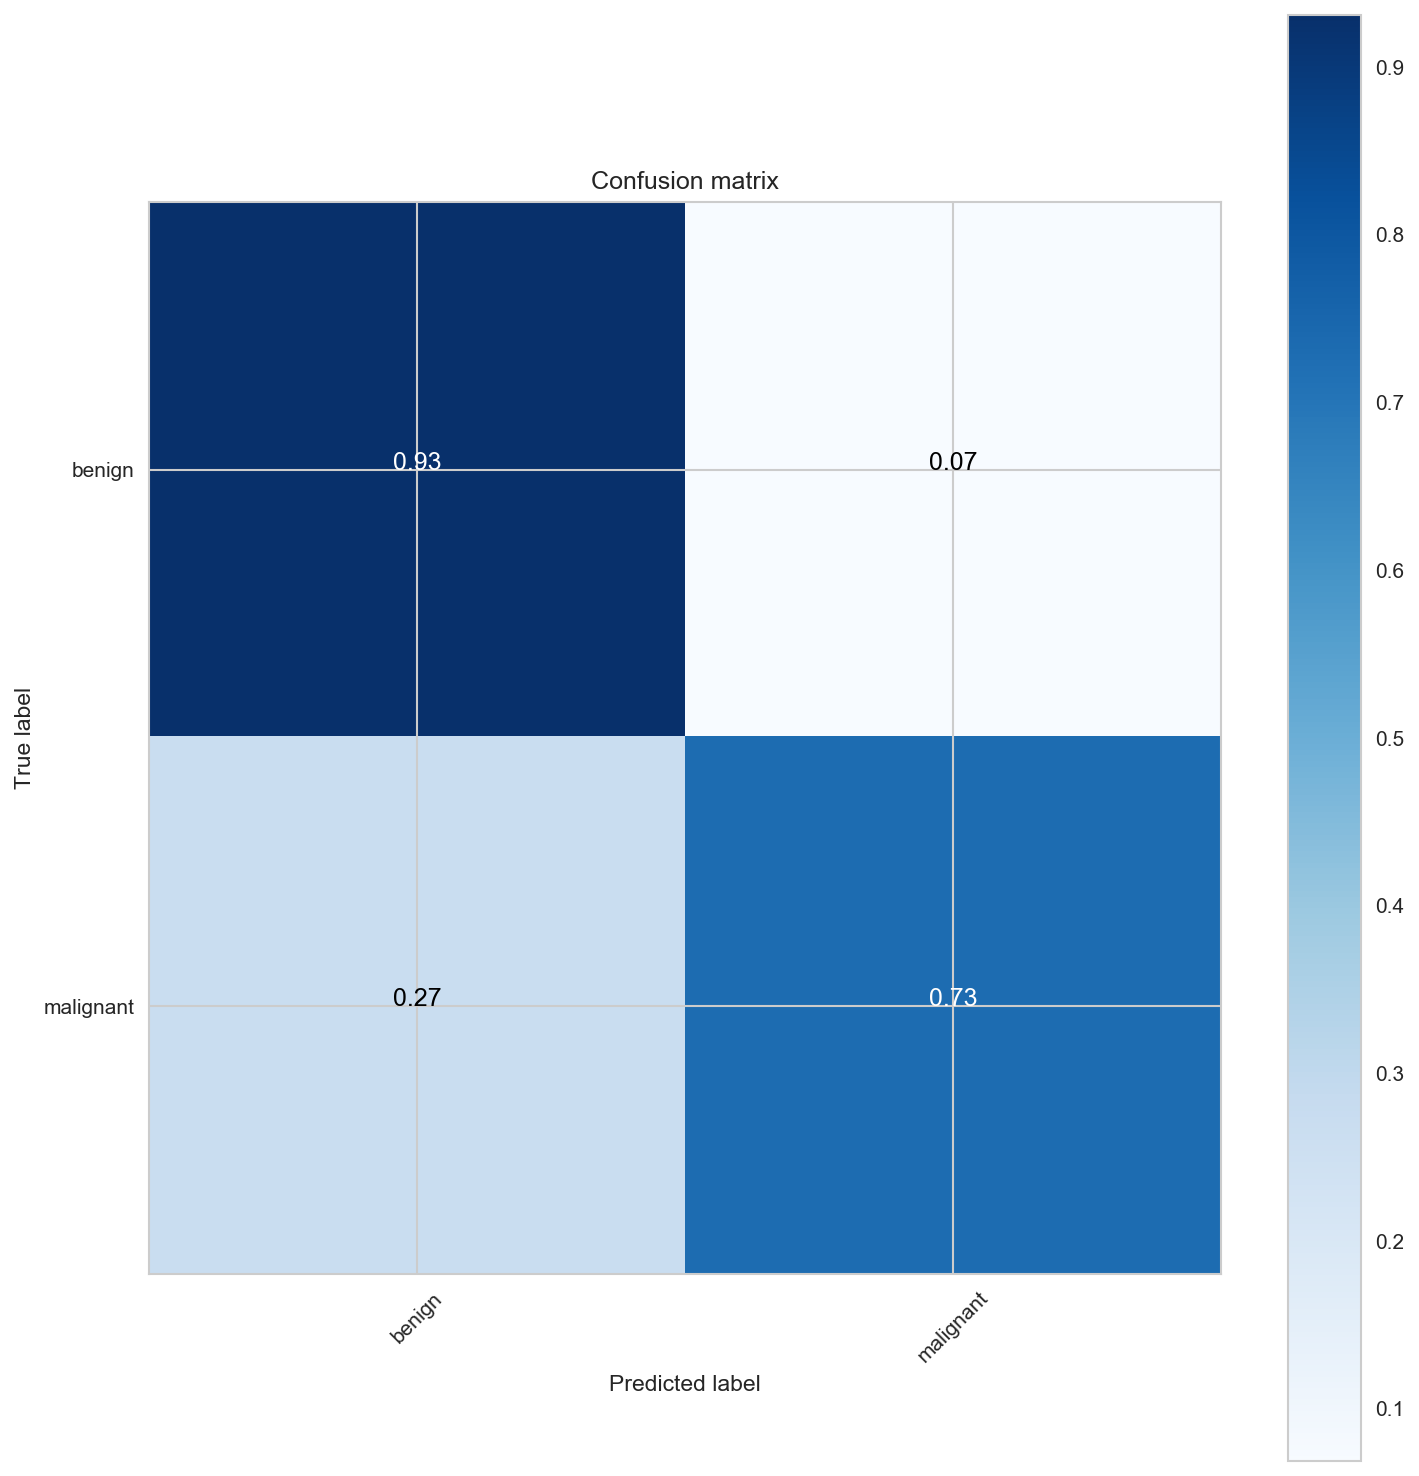

In [26]:
confusion_diagnostic(model, v_loader)

## Confusion matrix on the TEST set

Normalized confusion matrix


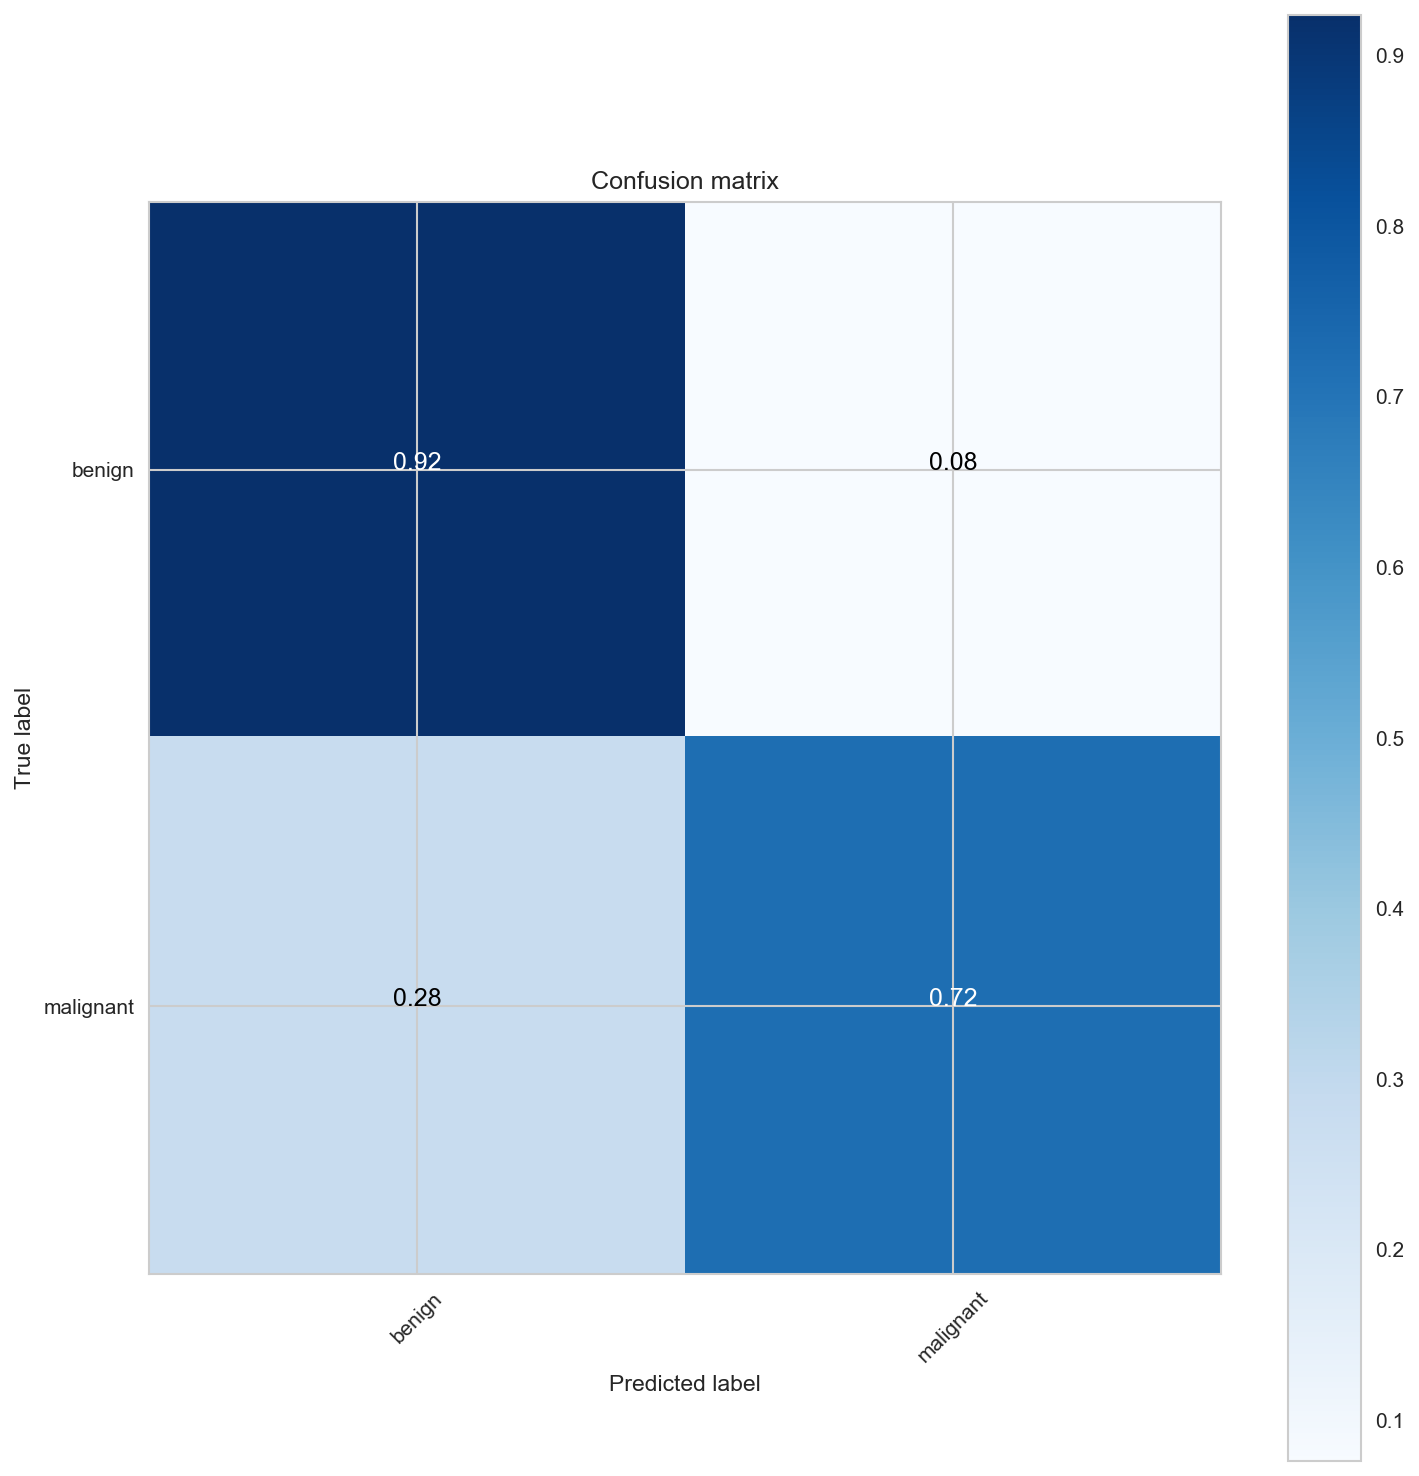

In [29]:
confusion_diagnostic(model, test_loader)